# Agent Long-Term Memory

Long-term memory persists user facts across sessions using stores with semantic search.

**What you'll learn:**
- Store persists data across sessions and threads
- PostgresStore with embeddings enables semantic search
- Tools access store via runtime.store
- Context provides user identification
- Namespaces organize memories hierarchically
- Semantic search finds relevant memories by meaning

## Memory Comparison

| Type | Storage | Use Case | Persistence |
|------|---------|----------|-------------|
| **Short-term** | Checkpointer | Conversation history | Session |
| **Long-term** | Store | User preferences, facts | Cross-session |

In [1]:
import sys
sys.path.append('../')

import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.agents import create_agent
from langchain.messages import HumanMessage
from langchain.tools import tool, ToolRuntime

from scripts import base_tools

In [3]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

system_prompt = """You are a helpful assistant with long-term memory.

MEMORY TOOLS USAGE:

save_user_memory - Save when user shares NEW information:
- Food preferences (diet, likes, dislikes, allergies)
- Work information (role, company, interests)  
- Hobbies and personal interests
- Location and timezone preferences

get_user_memory - Retrieve specific category:
- When answering questions about past preferences
- When user asks "what do you know about me?"
- When making personalized recommendations

web_search - Retrieve Real-time information
- When user ask about news or latest update
- When user ask about real-time information

GUIDELINES:
- Always save when user shares personal information
- Use stored preferences to personalize responses
- Be conversational and natural"""

## Setup PostgresStore

In [4]:
from dataclasses import dataclass
from langgraph.store.memory import InMemoryStore
from langgraph.store.sqlite import SqliteStore

from langgraph.store.postgres import PostgresStore
import psycopg

In [30]:
embeddings = GoogleGenerativeAIEmbeddings(model='gemini-embedding-001')

def embed(texts: list[str]):
    return embeddings.embed_documents(texts, output_dimensionality=768)


len(embed(['cat', 'dog']))

response = embed(['cat'])
len(response[0])

768

In [15]:
pg_conn = psycopg.connect(os.getenv('POSTGRESQL_URL'), autocommit=True)
store = PostgresStore(pg_conn, index={'embed': embed, 'dims': 768})
store.setup()

In [16]:
@dataclass
class UserContext:
    user_id: str

## Memory Tools with ToolRuntime

In [22]:
@tool
def save_user_memory(category: str, information:dict, runtime:ToolRuntime):
    """Save user preference or information to long-term memory.
    
    Args:
        category: Category of information (e.g., 'food', 'work', 'hobbies', 'location')
        information: Dictionary containing the information to save
        
    Examples:
        category='food', information={'diet': 'vegetarian', 'likes': ['pasta', 'pizza']}
        category='work', information={'role': 'Data Scientist', 'interests': ['AI', 'ML']}
    """

    store = runtime.store
    user_id = runtime.context.user_id

    namespace = (user_id, "preferences")

    store.put(namespace=namespace, key=category, value=information)

    return f"Saved {category} preferences for {user_id}"


In [23]:
@tool
def get_user_memory(category:str, runtime: ToolRuntime):
    """Retrieve user preference or information from long-term memory.
    
    Args:
        category: Category of information to retrieve (e.g., 'food', 'work', 'hobbies')
        
    Returns:
        Stored information for the category or "not found" message
    """

    store = runtime.store
    user_id = runtime.context.user_id

    namespace = (user_id, 'preferences')

    item = store.get(namespace=namespace, key=category)
    if item:
        return f"{category}: {item.value}"
    
    return f"No '{category}' information found"


## Agent with Long-Term Memory

In [32]:
from langgraph.checkpoint.postgres import PostgresSaver

# sort term memory fresh connection
pg_conn1 = psycopg.connect(os.getenv("POSTGRESQL_URL"), autocommit=True)
checkpointer = PostgresSaver(pg_conn1)

# long term memory fresh connection
pg_conn = psycopg.connect(os.getenv('POSTGRESQL_URL'), autocommit=True)
store = PostgresStore(pg_conn, index={'embed': embed, 'dims': 768})

agent = create_agent(
    model=model,
    tools=[base_tools.web_search, save_user_memory, get_user_memory],
    checkpointer=checkpointer,
    store=store,
    context_schema=UserContext,
    system_prompt=system_prompt
)

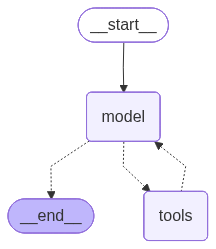

In [33]:
agent

## Save User Preferences

In [34]:
# Save user information
config = {"configurable": {"thread_id": "kgptalkie_session_3"}}
user_context = UserContext(user_id='kgptalkie')

response = agent.invoke({
    'messages': [HumanMessage("I'm a vegeterian and I love pasta. I live in Mumbai. I am a data scientist and AI Engineer.")]
}, config=config, context=user_context)

d:\Courses\Udemy\AI Agent Projects\.venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=UserContext(user_id='kgptalkie'), input_type=UserContext])
  return self.__pydantic_serializer__.to_python(


In [35]:
response

{'messages': [HumanMessage(content="I'm a vegeterian and I love pasta. I live in Mumbai. I am a data scientist and AI Engineer.", additional_kwargs={}, response_metadata={}, id='374e64b9-0260-4f43-b1c4-c933a5412cb4'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'save_user_memory', 'arguments': '{"category": "work", "information": {"role": "Data Scientist", "interests": ["AI", "ML"]}}'}, '__gemini_function_call_thought_signatures__': {'9c189c4b-68a2-4a9a-a9b6-009267bff071': 'CpcEAXLI2nxQxkhniw3T92Y/ZVBuJaz0V4F1Fa7YoOnr5eyoF7kfZ/Fh43qs+H9dbceVDLWHuD35TwPO8ug4Tj527tDfiQY21o5Txs8olqdi+iqXB5oVCfFBB6MScoz0xQQMFEZUEe3qhJ/+thYNRer3ykBPNywFOQU0tY/zgk2KHS994zIrihfLoVCLyJc7xY62juiCPs15O0jgH8lUlj9i2X92bsWKovoAoR0DHNfRSs4gmEyvb+eRrUjFERx9HVL98UD4Bxa8tUNXP7xnWDRp/rz4eS7BjNMmwIeU6gC9L8Z7FjF5duOHBOwGXg2n+MG+Xq40Z11ieC0WgtJt2oPviU5vUOq5d97LB2YHcuwvjFTDpn4qDBEZNwr7tsrYZDPjV/SssyXWr36OD2MIiSpOEJUdCuvhVtc0SCYp8aOodz3HLgqFrTTEmlPUAAKCrjTNwQpqu7I+LyPLqhS0MxGDACPqSO4JC224Wya1UnipfFQ/

## Retrieve in New Session

In [46]:
def get_agent():
    # sort term memory fresh connection
    pg_conn1 = psycopg.connect(os.getenv("POSTGRESQL_URL"), autocommit=True)
    checkpointer = PostgresSaver(pg_conn1)

    # long term memory fresh connection
    pg_conn = psycopg.connect(os.getenv('POSTGRESQL_URL'), autocommit=True)
    store = PostgresStore(pg_conn, index={'embed': embed, 'dims': 768})

    agent = create_agent(
        model=model,
        tools=[base_tools.web_search, save_user_memory, get_user_memory],
        checkpointer=checkpointer,
        store=store,
        context_schema=UserContext,
        system_prompt=system_prompt
    )

    return agent

# Save user information
config = {"configurable": {"thread_id": "kgptalkie_session_5"}}
user_context = UserContext(user_id='kgptalkie')

agent = get_agent()
response = agent.invoke({
    'messages': [HumanMessage("what do you know about my preferences?")]
}, config=config, context=user_context)

response

d:\Courses\Udemy\AI Agent Projects\.venv\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=UserContext(user_id='kgptalkie'), input_type=UserContext])
  return self.__pydantic_serializer__.to_python(


{'messages': [HumanMessage(content='what do you know about my preferences?', additional_kwargs={}, response_metadata={}, id='b3b2db4a-ad11-4f4f-8c5a-0b12fa91753d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_user_memory', 'arguments': '{"category": "location"}'}, '__gemini_function_call_thought_signatures__': {'f3708866-57bf-43aa-b388-fd378c7999c6': 'CtsDAXLI2nzRto0xBt2YnBxFkuty04wdyL4/jxDhqjhA0q0WrGFSw9fAyp8Y1yVFk/TIJ6OIo2SqY/9F9qxJ79r1Ycp9HzTi1aRAdxBfSKuAO/xgB9b7BWfVwJCI7sNe2Z5k7HfMrZYXxNzz/FgacmTiJL9ZXkFY2Xi1ZAFWwmaW3zfCRTN1O8u2bgYISxL6PALymV/Is317p2Ml8FfFCaS6dfleoMluKYuE4tZmSPrKR1wEa9GboDe1fdWv2GjfPrcGAg55VI53rZyTWFyuvXP9uPdt3yc9ivSHmP5xGLvkPXtT5B3UdQTgQGfTLfJwzwRgyDkgLhIPSXjk3851Mw+BFJJ/i3cuuW/NfKpNOzr2Oi5cEfnCopm3cnLnWltKFaK4eetNAYw3tTB/8+bibUizgLOC8FCAMZZUW/k0NIBC9JZlC5FY1QlX801LvKFVSkwnaJgl+lr0+8sTUtpI6MH8OfwoLxcB3KhX0udXm7MFuyC2QOyKllVaBmR/FxG3w0KjYpqj6DU+FRfT9GnTOg+F1IisyuxGKfqLgdo0TzhOlJNekopzYAxJGJmfSqZObljPsMc+Sq+nQCCT6zjNJmVQESxVZAzHphfgTMS+

In [55]:
agent = get_agent()
response = agent.invoke({
    'messages': [HumanMessage("Can you recommend a restaurant for me? use web search and don't ask back question.")]
}, config=config, context=user_context)

response

{'messages': [HumanMessage(content='what do you know about my preferences?', additional_kwargs={}, response_metadata={}, id='b3b2db4a-ad11-4f4f-8c5a-0b12fa91753d'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_user_memory', 'arguments': '{"category": "location"}'}, '__gemini_function_call_thought_signatures__': {'f3708866-57bf-43aa-b388-fd378c7999c6': 'CtsDAXLI2nzRto0xBt2YnBxFkuty04wdyL4/jxDhqjhA0q0WrGFSw9fAyp8Y1yVFk/TIJ6OIo2SqY/9F9qxJ79r1Ycp9HzTi1aRAdxBfSKuAO/xgB9b7BWfVwJCI7sNe2Z5k7HfMrZYXxNzz/FgacmTiJL9ZXkFY2Xi1ZAFWwmaW3zfCRTN1O8u2bgYISxL6PALymV/Is317p2Ml8FfFCaS6dfleoMluKYuE4tZmSPrKR1wEa9GboDe1fdWv2GjfPrcGAg55VI53rZyTWFyuvXP9uPdt3yc9ivSHmP5xGLvkPXtT5B3UdQTgQGfTLfJwzwRgyDkgLhIPSXjk3851Mw+BFJJ/i3cuuW/NfKpNOzr2Oi5cEfnCopm3cnLnWltKFaK4eetNAYw3tTB/8+bibUizgLOC8FCAMZZUW/k0NIBC9JZlC5FY1QlX801LvKFVSkwnaJgl+lr0+8sTUtpI6MH8OfwoLxcB3KhX0udXm7MFuyC2QOyKllVaBmR/FxG3w0KjYpqj6DU+FRfT9GnTOg+F1IisyuxGKfqLgdo0TzhOlJNekopzYAxJGJmfSqZObljPsMc+Sq+nQCCT6zjNJmVQESxVZAzHphfgTMS+

## Semantic Search

In [52]:
# long term memory fresh connection
pg_conn = psycopg.connect(os.getenv('POSTGRESQL_URL'), autocommit=True)
store = PostgresStore(pg_conn, index={'embed': embed, 'dims': 768})

# Direct store access for semantic search
namespace = ('kgptalkie', 'preferences')
memories = store.search(namespace, query="What does the user like to eat?", limit=2)

for m in memories:
    print(f"{m.key}: {m.value}")

food: {'diet': 'vegetarian', 'likes': ['pasta']}
work: {'role': 'Data Scientist', 'interests': ['AI', 'ML']}


In [54]:
# Direct store access for semantic search
namespace = ('kgptalkie', 'preferences')
memories = store.search(namespace, query="where user works and what is users profession", limit=2)

for m in memories:
    print(f"{m.key}: {m.value}")

work: {'role': 'Data Scientist', 'interests': ['AI', 'ML']}
food: {'diet': 'vegetarian', 'likes': ['pasta']}
